# Imports 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import networkx as nx
import scipy.io
import pickle
from pagerank import PageRank 

In [81]:
sns.set_palette(palette='deep', n_colors=1)

# Load datasets

In [2]:
wiki_matrix = scipy.io.loadmat('simple_wiki_matrix.mat')['W']
stan_graph = nx.read_edgelist("web-Stanford.txt", create_using=nx.DiGraph(), nodetype=int)

In [3]:
articles_ = []
with open('simple_wiki_dict.pickle', 'rb') as f:
    while True:
        try:
            temp = pickle._Unpickler(f)
            temp.encoding = 'utf-8'
            articles_.append(temp.load())
        except EOFError:
            break

articles = articles_[0]

# PageRank methods

In [4]:
pr = PageRank(data=stan_graph)

In [5]:
pr.set_custom_attributes()

## Power method

In [6]:
n_iter = 200
ranks, residuals1 = pr.power_method(x0=np.ones(pr.size) / pr.size, n_iter=n_iter, 
                                   return_residuals=True)

In [7]:
pr.show_ranks()

,Power Method
node_id,
89073,0.011303
226411,0.009268
241454,0.008297
262860,0.003023
134832,0.003001


## Markov chain Monte Carlo

In [8]:
pr.mcmc(n_iter=int(1e5))

In [9]:
pr.show_ranks(5, sort_by='MCMC')

,Power Method,MCMC
node_id,,
89073,0.011303,0.01005
226411,0.009268,0.00918
241454,0.008297,0.00827
262860,0.003023,0.00285
134832,0.003001,0.00251


## Frank-Wolfe

In [50]:
n_iter = 1000
ranks, targets1_ls, residuals = pr.frank_wolfe(x0=np.ones(pr.size) / pr.size,
                                           n_iter=n_iter, 
                                           step='line_search', 
                                           return_targets=True, 
                                           return_residuals=False)

In [51]:
n_iter = 1000
ranks, targets1_na, residuals = pr.frank_wolfe(x0=np.ones(pr.size) / pr.size,
                                           n_iter=n_iter, 
                                           step='nonadaptive', 
                                           return_targets=True, 
                                           return_residuals=False)

In [45]:
len(targets)

1000

Text(0.5,0,'Iterations')

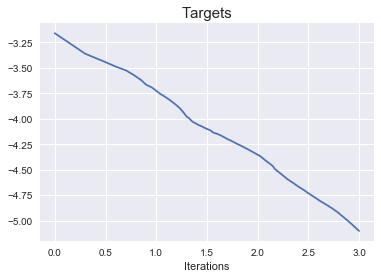

In [46]:
n_last = n_iter
plt.plot(np.log(np.arange(1, n_iter + 1)) / np.log(10), 
         np.log(targets) / np.log(10))
plt.title('Targets', fontsize=15)
plt.xlabel('Iterations')

In [49]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.log(np.arange(1, n_iter + 1)[1:1000]).reshape(-1, 1), 
          np.log(targets[1:1000]).reshape(-1, 1))
print(model.coef_[0, 0])
k1 = model.coef_[0, 0]

-0.6822881829973094


In [16]:
pr.show_ranks()

,Power Method,MCMC,Frank-Wolfe
node_id,,,
89073,0.011303,0.01005,0.014978
226411,0.009268,0.00918,0.017018
241454,0.008297,0.00827,0.013002
262860,0.003023,0.00285,0.001480
134832,0.003001,0.00251,0.006751


In [13]:
np.linalg.norm(pr.fw_ranks - pr.pm_ranks)

0.017610484492370473

In [17]:
np.linalg.norm(pr.fw_ranks - pr.pm_ranks)

0.016087932475620334

# English Wikipedia

## Compute

In [53]:
wiki = PageRank(data=wiki_matrix)

In [54]:
wiki.set_custom_attributes()

In [55]:
x0 = np.random.uniform(size=wiki.size)
x0 /= np.linalg.norm(x0, ord=1)
n_iter = 200
ranks, residuals2 = wiki.power_method(x0=x0, n_iter=n_iter, return_residuals=True)

In [56]:
wiki.mcmc(n_iter=int(1e5))

In [57]:
wiki.show_ranks()

,Power Method,MCMC
node_id,,
880,0.002905,0.00327
69741,0.002068,0.00226
113673,0.001544,0.00170
486,0.001356,0.00138
34525,0.001286,0.00139


In [112]:
ranks, targets2_ls, residuals = wiki.frank_wolfe(x0, n_iter=1000, 
                                                 step='line_search', 
                                                 return_targets=True, 
                                                 return_residuals=True)

In [59]:
ranks, targets2_na, residuals = wiki.frank_wolfe(x0, n_iter=1000, 
                                                 step='nonadaptive', 
                                                 return_targets=True, 
                                                 return_residuals=True)

## Results

In [55]:
pm_top_indeces = np.array(list(wiki.show_ranks(sort_by='Power Method').index)) - 1
mcmc_top_indeces = np.array(list(wiki.show_ranks(sort_by='MCMC').index)) - 1
fw_top_indeces = np.array(list(wiki.show_ranks(sort_by='Frank-Wolfe').index)) - 1

In [60]:
print('------- TOP WIKI-ARTICLES ACCORDING TO POWER METHOD!!! -------')
print()
for i in range(len(pm_top_indeces)):
    print("{}. {}".format(i + 1, articles[pm_top_indeces[i]]))
print()

print('------- TOP WIKI-ARTICLES ACCORDING TO MCMC!!! -------')
print()
for i in range(len(mcmc_top_indeces)):
    print("{}. {}".format(i + 1, articles[mcmc_top_indeces[i]]))
print()

print('------- TOP WIKI-ARTICLES ACCORDING TO FRANK-WOLFE!!! -------')
print()
for i in range(len(fw_top_indeces)):
    print("{}. {}".format(i + 1, articles[fw_top_indeces[i]]))
print()

------- TOP WIKI-ARTICLES ACCORDING TO POWER METHOD!!! -------

1. United_States
2. Multimedia
3. Geographic_coordinate_system
4. France
5. Americans

------- TOP WIKI-ARTICLES ACCORDING TO MCMC!!! -------

1. United_States
2. Multimedia
3. Geographic_coordinate_system
4. France
5. Americans

------- TOP WIKI-ARTICLES ACCORDING TO FRANK-WOLFE!!! -------

1. United_States
2. Multimedia
3. Americans
4. France
5. Geographic_coordinate_system



In [113]:
df = wiki.show_ranks(n_first=wiki.size)
df.sort_index(inplace=True)
df['Article'] = list(articles.values())
df.sort_values(by='Power Method', ascending=False, inplace=True)
df.set_index('Article', inplace=True)
df.head()

,Power Method,MCMC,Frank-Wolfe
Article,,,
United_States,0.002905,0.00327,0.004501
Multimedia,0.002068,0.00226,0.002472
Geographic_coordinate_system,0.001544,0.00170,0.002145
France,0.001356,0.00138,0.002190
Americans,0.001286,0.00139,0.002200


In [115]:
df.head().to_latex('top5.tex')

# Visualization

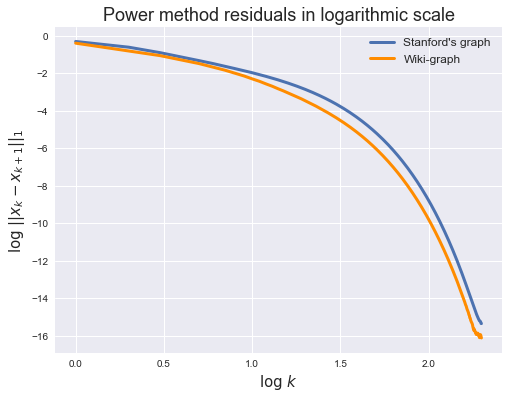

In [37]:
n_iter = 200
n_last = 200
plt.figure(figsize=(8, 6))
plt.plot(np.log(np.arange(n_iter - n_last, n_iter)) / np.log(10), 
         np.log(residuals1[-n_last:]) / np.log(10), 
         lw=3, label="Stanford's graph")
plt.plot(np.log(np.arange(n_iter - n_last, n_iter)) / np.log(10), 
         np.log(residuals2[-n_last:]) / np.log(10), 
         lw=3, color='darkorange',
         label="Wiki-graph")
plt.title('Power method residuals in logarithmic scale', fontsize=18)
plt.xlabel('$\log\ k$', fontsize=15)
plt.ylabel('$\log\ ||x_k - x_{k+1}||_1$', fontsize=15)
plt.legend(fontsize=12)
plt.savefig('pm_residuals.pdf')

In [102]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.log(100 * np.arange(1, len(pr.mcmc_deviations) + 1)).reshape(-1, 1), 
          np.log(np.array(pr.mcmc_deviations)).reshape(-1, 1))
print(model.coef_[0, 0])
k1 = model.coef_[0, 0]

model.fit(np.log(100 * np.arange(1, len(wiki.mcmc_deviations) + 1)).reshape(-1, 1), 
          np.log(np.array(wiki.mcmc_deviations)).reshape(-1, 1))
print(model.coef_[0, 0])
k2 = model.coef_[0, 0]

-0.4987419669233175
-0.4891991730661198


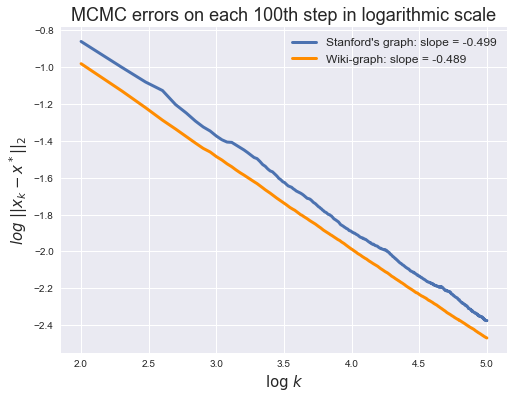

In [128]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(100 * np.arange(1, len(pr.mcmc_deviations) + 1)) / np.log(10), 
         np.log(np.array(pr.mcmc_deviations)) / np.log(10), 
         lw=3, 
         label="Stanford's graph: slope = {}".format(round(k1, 3)))
plt.plot(np.log(100 * np.arange(1, len(wiki.mcmc_deviations) + 1)) / np.log(10), 
         np.log(np.array(wiki.mcmc_deviations)) / np.log(10), 
         lw=3, color='darkorange',
         label="Wiki-graph: slope = {}".format(round(k2, 3)))
plt.title('MCMC errors on each 100th step in logarithmic scale', fontsize=18)
plt.xlabel('$\log\ k$', fontsize=15)
plt.ylabel('$log\ ||x_k - x^*||_2$', fontsize=15)
plt.legend(fontsize=12)
plt.savefig('mcmc_errors.pdf')

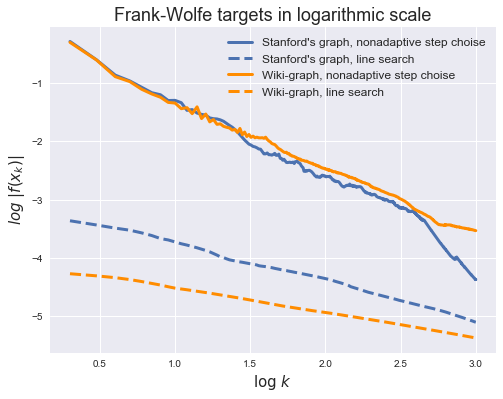

In [84]:
plt.figure(figsize=(8, 6))
plt.plot(np.log(np.arange(2, len(targets1_na) + 1)) / np.log(10), 
         np.log(targets1_na[1:]) / np.log(10), lw=3,
         label="Stanford's graph, nonadaptive step choise")
plt.plot(np.log(np.arange(2, len(targets1_na) + 1)) / np.log(10), 
         np.log(targets1_ls[1:]) / np.log(10), lw=3, ls='--',
         label="Stanford's graph, line search")
plt.plot(np.log(np.arange(2, len(targets1_na) + 1)) / np.log(10), 
         np.log(targets2_na[1:]) / np.log(10), lw=3, c='darkorange',
         label="Wiki-graph, nonadaptive step choise")
plt.plot(np.log(np.arange(2, len(targets1_na) + 1)) / np.log(10), 
         np.log(targets2_ls[1:]) / np.log(10), lw=3, ls='--', c='darkorange',
         label="Wiki-graph, line search")
plt.title('Frank-Wolfe targets in logarithmic scale', fontsize=18)
plt.xlabel('$\log\ k$', fontsize=15)
plt.ylabel('$log\ |f(x_k)|$', fontsize=15)
plt.legend(fontsize=12)
plt.savefig('frank_wolfe_targets.pdf')